## Initial Code Analysis ##

In [30]:
# setup steps #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

ocha_data_df = pd.read_csv('ocha_weighted_avg.csv')
piv_ocha_df = pd.read_csv('ocha_needs_met_pivot.csv')

In [31]:
# group and pivot for OCHA needs met #
piv_ocha_df = piv_ocha_df.reset_index(drop=True) 
piv_ocha_df['pct_fund'] = piv_ocha_df['% funding']
piv_ocha_df['pct_fund'] = piv_ocha_df['pct_fund'].str.replace('%', '', regex=False)
piv_ocha_df['pct_fund'] = pd.to_numeric(piv_ocha_df['pct_fund'], errors= 'coerce')
piv_ocha_df['pct_fund'] = piv_ocha_df['pct_fund']/100

# exploding out the data from the grouped format
def split_and_explode_countries(df):
    df_new = df.copy()

    def handle_country(country):
        if isinstance(country, str):
            return country.split(',')
        elif isinstance(country, list):
            return country
        else: 
            try: 
                return [str(country)] 
            except Exception: 
                return [str(country)]  # Handle potential errors during conversion

    df_new['Country'] = df_new['Country'].apply(handle_country)
    df_new = df_new.explode('Country') 
    df_new['Country'] = df_new['Country'].str.strip() 

    return df_new

piv_ocha_df['Country'] = piv_ocha_df['Country'].astype(str)

new_pivdf = split_and_explode_countries(piv_ocha_df) 

# Group by country and year, calculate average % Funding
grouped_df = new_pivdf.groupby(['Country', 'Year'])['pct_fund'].mean().reset_index()

# filter to just our OCHA countries of interest
target_countries = ['Afghanistan', 'Burkina Faso', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo', 'Djibouti', 'Haiti', 'Iraq', 'Libya', 'Mali', 'Mauritania', 'Myanmar', 'Niger', 'Nigeria', 'Occupied Palestinian Territory', 'South Sudan', 'Somalia', 'Sudan', 'Syrian Arab Republic', 'Ukraine', 'Yemen', 'Zimbabwe']
filtered_df = grouped_df[grouped_df['Country'].isin(target_countries)]


# Create the line chart using Altair
chart = alt.Chart(filtered_df).mark_line().encode(
    x=alt.X('Year:O', title='Year'), 
    y=alt.Y('pct_fund:Q', axis=alt.Axis(format='%', title='Percentage Funding Request Recieved')), 
    color='Country',
    tooltip=['Year', 'Country', alt.Tooltip('pct_fund', format='.2%')]
).properties(
    title='Average % Funding by Country Over Time',
    width=600  
).interactive()

chart.show() 

alt.Chart(...)

# Adding variables, exploring our data #

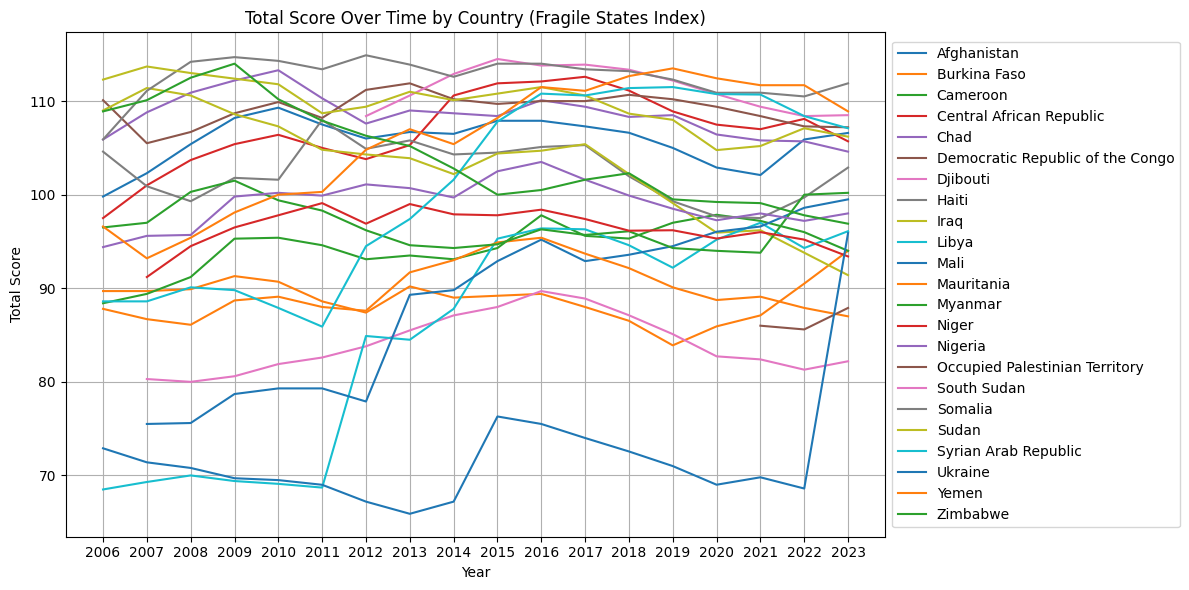

In [32]:
# compiling summary insights from the Fragile States Index #
import glob
import re

fsi_excel_files = sorted(glob.glob("Fragile States Index/fsi-*.xlsx")) 

# country level data alignment
country_data = {}
column_names = ['Total', 'C1: Security Apparatus',	'C2: Factionalized Elites',	'C3: Group Grievance',	'E1: Economy',	'E2: Economic Inequality',	'E3: Human Flight and Brain Drain',	'P1: State Legitimacy',	'P2: Public Services',	'P3: Human Rights',	'S1: Demographic Pressures',	'S2: Refugees and IDPs',	'X1: External Intervention']

# for loops to pull and merge data
for file in fsi_excel_files:
    # Extract the year using a regular expression
    match = re.search(r"(\d{4})", file)
    if match:
        year = int(match.group(1))
    else:
        print(f"Warning: Could not extract year from filename: {file}")
        continue  # Skip to the next file

    df = pd.read_excel(file)

    for index, row in df.iterrows():
        country = row['Country']
        if country not in country_data:
            country_data[country] = {}

        for col in column_names:
            country_data[country][f'{year}_{col}'] = row[col] 

# 3. Convert the dictionary to a DataFrame
fsi_final_df = pd.DataFrame.from_dict(country_data, orient='index')

# 4. Handle missing values (important!)
fsi_final_df = fsi_final_df.fillna(pd.NA) 

# 5. Save to a new Excel file
fsi_final_df.to_excel("combined_fsi_data.xlsx") 

# Plotting to test efficacy
plot_data = fsi_final_df.copy()

# Extract the '(year)_Total' columns
total_columns = [col for col in plot_data.columns if col.endswith("_Total")]
plot_data = plot_data[total_columns]

# Transpose the data for plotting
plot_data = plot_data.T  # Rows become years, columns become countries
plot_data.index = plot_data.index.map(lambda x: int(x.split("_")[0]))

# Filtering to target country set
country_name_mapping = {
    "Congo Democratic Republic": "Democratic Republic of the Congo",
    "Palestine": "Occupied Palestinian Territory",
    "Syria": "Syrian Arab Republic"
}
plot_data = plot_data.rename(columns=country_name_mapping)
target_countries = ['Afghanistan', 'Burkina Faso', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo', 'Djibouti', 'Haiti', 'Iraq', 'Libya', 'Mali', 'Mauritania', 'Myanmar', 'Niger', 'Nigeria', 'Occupied Palestinian Territory', 'South Sudan', 'Somalia', 'Sudan', 'Syrian Arab Republic', 'Ukraine', 'Yemen', 'Zimbabwe']
plot_data_filtered = plot_data[target_countries]


# 8. Create the plot
plt.figure(figsize=(12, 6))

for country in plot_data_filtered.columns:  # Iterate over the filtered columns
    plt.plot(plot_data_filtered.index, plot_data_filtered[country], label=country)

plt.xlabel("Year")
plt.xticks(plot_data_filtered.index, plot_data_filtered.index.astype(int))
plt.ylabel("Total Score")
plt.title("Total Score Over Time by Country (Fragile States Index)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# compiling summary insights from the World Risk Index #

wri_csv_files = sorted(glob.glob("World Risk Index/worldriskindex-datasets/worldriskindex-*.csv")) 

# country level data alignment
wri_country_data = {}
wri_column_names = [
    'W', 'E', 'V', 'S', 'C', 'A', 
    'S_01', 'S_02', 'S_03', 'S_04', 'S_05', 
    'C_01', 'C_02', 'C_03', 
    'A_01', 'A_02', 'A_03', 
    'EI_01', 'EI_02', 'EI_03', 'EI_04', 'EI_05', 'EI_06', 'EI_07', 
    'SI_01', 'SI_02', 'SI_03', 'SI_04', 'SI_05', 'SI_06', 'SI_07', 'SI_08', 'SI_09', 'SI_10', 'SI_11', 'SI_12', 'SI_13', 'SI_14', 
    'CI_01', 'CI_02', 'CI_03', 'CI_04', 'CI_05', 'CI_06', 'CI_07', 
    'AI_01', 'AI_02', 'AI_03', 'AI_04'
]
# for loops to pull and merge data
for file in wri_csv_files:
    # Extract the year using a regular expression
    match = re.search(r"(\d{4})", file)
    if match:
        year = int(match.group(1))
    else:
        print(f"Warning: Could not extract year from filename: {file}")
        continue

    df = pd.read_csv(file)

    for index, row in df.iterrows():
        country = row['Country']
        if country not in wri_country_data:  # Use wri_country_data
            wri_country_data[country] = {}

        for col in wri_column_names:
            wri_country_data[country][f'{year}_{col}'] = row[col]

# Convert the dictionary to a DataFrame
wri_final_df = pd.DataFrame.from_dict(wri_country_data, orient='index')

wri_final_df = wri_final_df.fillna(pd.NA)

# 5. Save to a new Excel file
wri_final_df.to_excel("combined_wri_data.xlsx")

print(wri_final_df.head(5))


             2000_W  2000_E  2000_V  2000_S  2000_C  2000_A  2000_S_01  \
Afghanistan    4.19    0.25   70.32   61.91   78.59   71.47      65.90   
Albania        6.53    2.38   17.94   12.58   44.15   10.40      53.08   
Algeria       10.29    2.65   39.94   30.07   51.99   40.76      48.02   
Andorra        0.32    0.02    5.21    2.58    2.18   25.10      33.23   
Angola        11.06    2.18   56.09   35.52   65.02   76.41      59.61   

             2000_S_02  2000_S_03  2000_S_04  ...  2024_CI_02  2024_CI_03  \
Afghanistan      70.66      70.10      59.38  ...       93.79       78.22   
Albania          15.47      36.27       2.05  ...        0.01       49.23   
Algeria          35.44      43.51       8.87  ...       41.00       58.18   
Andorra           0.54      30.52       0.01  ...        0.01       26.43   
Angola           64.24      81.51       2.59  ...       38.65       62.95   

             2024_CI_04  2024_CI_05  2024_CI_06  2024_CI_07  2024_AI_01  \
Afghanistan      

In [41]:
# Testing the depth/quality of our data #
import pycountry 

inform_df = pd.read_csv('INFORM/inform2014_2023.csv')
ndgain_df = pd.read_csv('ND GAIN/resources/gain/gain_delta.csv')

country_cross_df = pd.read_csv('country_code_crosswalk.csv')
wri_cross_df = pd.read_csv('worldrisk_code_cross.csv')

# translating from the coded country names - INFORM only
def iso3_to_name(iso3_code):
    try:
        country = pycountry.countries.lookup(iso3_code)
        return country.name
    except LookupError:
        return None
    
inform_df['country_name'] = inform_df['Iso3'].apply(iso3_to_name)
inform_filtered = inform_df[inform_df['country_name'].isin(target_countries)]

inform_filtered.to_excel("INFORM_filtered.xlsx")